In [1]:
import os
import sys
import numpy as np
import pandas as pd
from Bio import SeqIO
import matplotlib.pylab as plt
%matplotlib inline

In [2]:
os.getcwd()
os.listdir()

['.Rhistory',
 'js1_bi.csv',
 'BreakPointDistance.csv',
 'Bipartite_graph.ipynb',
 'Junction_Sequences_NTRK1_nonCRC_4_19_20_deid.xlsx',
 '.DS_Store',
 'ucsc_genes.tsv',
 'Table1.rds',
 'data_Junction_Regions_CRC_4_19_20_deid.fa',
 'nonCRC_Table1.pkl',
 'Fusion_Gene_ NTRK1_partners.ipynb',
 'Genome Screenshots',
 'Strand_specificity_plot.ipynb',
 'Window_boxplot_J2.ipynb',
 'Fusion_Gene_nonCRC.ipynb',
 'Window_lineplot.ipynb',
 'Junction_Sequences_CRC_4_19_20_deid.xlsx',
 'js1_count.pkl',
 'Bed_files_for_USCS_plot.ipynb',
 '.RData',
 'nonCRC_gene1_bed',
 'CRC_gene1_bed',
 'Table1.pkl',
 'CRC_gene2_bed',
 'Window_boxplot_J1.ipynb',
 '.ipynb_checkpoints',
 'humanFreq.png',
 'CRC_gene1_bed.zip',
 'Fusion_Gene_R.ipynb',
 'Fusion_Gene_CRC.ipynb',
 'MSS_MSI_review.pptx',
 'Re__Windows_in_oncogenic_gene..zip',
 'Fusion_Gene_R.R',
 'data_Junction_Regions_CRC_4_19_20_deid_J2.fa',
 'CeCe_Proj']

# Functions

In [38]:
# GC content related functions

def cound_mononucleotide(i):
    A_ct = i.count('A') + i.count('a')
    T_ct = i.count('T') + i.count('t')
    C_ct = i.count('C') + i.count('c')
    G_ct = i.count('G') + i.count('g')
    tmp = {'A':A_ct, 'T':T_ct, 'C':C_ct,'G':G_ct}
    return tmp

def count_mono_series(indexed): #takes in a series, returns a dictionary
    save = {}
    for i in range(len(indexed)):
        save[indexed.index[i]] = cound_mononucleotide(indexed[i])
    return save

def my_referse_complement(seq):
    complement = {'A': 'T', 'C': 'G', 'G': 'C', 'T': 'A'}
    return "".join(complement.get(base, base) for base in reversed(seq))

def combine_rc_percentage(dg): #takes in a dataframe, returns a data frame
    df = dg.copy()
    df['count'] = df.sum(axis=1)
    cols_rest = list(df.columns)
    cols_1 = []
    cols_2 = []
    for i in df.columns:
        reverse_tmp = my_referse_complement(i)
        if reverse_tmp in list(df.columns):
            cols_rest.remove(i)
            if reverse_tmp not in cols_1:
                cols_1.append(i)
                cols_2.append(reverse_tmp)   
    dt = pd.DataFrame()
    #cols_c = []
    for i,j in zip(cols_1,cols_2):
        if i==j:
            #cols_c.append(i)
            dt[i] = df[i]/df['count']
        else:
            k = i+"+"+j
            #cols_c.append(k)
            dt[k] = (df[i]+df[j])/df['count']           
    dt = pd.concat([dt, df[cols_rest]], axis=1)
    return dt

#vactorized String Operations: https://jakevdp.github.io/PythonDataScienceHandbook/03.10-working-with-strings.html
def GC_percentage_series(series): #takes in a series returns a series
    ser = series.str.upper()
    total = ser.str.len()
    gc_count = ser.str.count("C") + ser.str.count("G") + ser.str.count("c") + ser.str.count("g")
    gc_percent = gc_count/total
    return gc_percent
    

# Extract info from sequence ID

def Split_IDs(df):
    dt = df.copy()
    # Drop MSI ambiguous records
    dt = dt[ ~ dt["IDs"].str.endswith('MSI')] # inverting (~) boolean mask
    # Split - Vectorized string functions for Series and Index
    dt[['Chr','Pos','ID1', 'ID2','MSIstatus','Junction','Gene']] = dt.IDs.str.split(':', expand=True)
    dt = dt.drop(columns = 'IDs')
    return dt

def Split_IDs_drop_merge(df):
    dt = df.copy()
    # Drop MSI ambiguous records
    dt = dt[ ~ dt["IDs"].str.endswith('MSI')] # inverting (~) boolean mask
    # Split - Vectorized string functions for Series and Index
    dt[['Chr','Pos','ID1', 'ID2','MSIstatus','Junction','Gene']] = dt.IDs.str.split(':', expand=True)
    dt = dt.drop(columns = ['IDs','Pos','ID1'])
    dt['ID2'] = dt['ID2'] + "_" + dt['Gene']
    return dt


# Reverse sequence on the (-) strand

def reverse_crick_sequence(df, seq_handle = "50+1+50", strand_handle = 'strand'):
    dt = df.copy().dropna()
    condition = dt[strand_handle] == "-"
    dt[seq_handle].loc[condition] = dt[seq_handle].loc[condition].apply(lambda x: x[::-1])
    return dt

def reverse_sequence_for_crick_genes(fasta_table, strand_ID2):
    df = Split_IDs_drop_merge(fasta_table)
    df = df.join(strand_ID2.set_index('ID2'), on= 'ID2')
    df = reverse_crick_sequence(df)
    return df


# Window related functions

def roughly_any_bp(df, wing=2, centre=51):
    tmp = df.copy()
    bp = wing*2 + 1
    tmp["{}bp".format(bp)] =tmp["50+1+50"].str.slice(centre-wing-1, centre+wing)
    tmp.drop(tmp.columns[0],axis=1,inplace = True) #drop '50+1+50'
    return tmp
def roughly_many_bp(df, wings=(0,2,10), centre=51):
    tmp = df.copy()
    for wing in wings:
        bp = wing*2 + 1
        tmp[str(bp)]=tmp["50+1+50"].str.slice(centre-wing-1, centre+wing)
    tmp.drop(tmp.columns[0],axis=1,inplace = True) #drop '50+1+50'
    return tmp

def roughly_any_bp_GC(df, wing=2, centre=51):
    tmp = df.copy()
    bp = wing*2 + 1
    tmp["{}bp".format(bp)] = GC_percentage_series(tmp["50+1+50"].str.slice(centre-wing-1, centre+wing))
    tmp.drop(tmp.columns[0],axis=1,inplace = True) #drop '50+1+50'
    return tmp
def roughly_many_bp_GC(df, wings=(0,2,10), centre=51):
    tmp = df.copy()
    for wing in wings:
        bp = wing*2 + 1
        tmp[str(bp)] = GC_percentage_series(tmp["50+1+50"].str.slice(centre-wing-1, centre+wing))
    tmp.drop(tmp.columns[0],axis=1,inplace = True) #drop '50+1+50'
    return tmp


# Plot GC content at individual bases

def split_seq_to_base(df, seq_handle = "50+1+50", seqlen = 101):
    dt = df.copy()
    for i in range(0,seqlen):
        dt.insert(loc=i, column=i, value=dt[seq_handle].str[i])
    return dt

def GC_base_table(df):
    dt = df.copy()
    grouped = dt.groupby(["Gene","MSIstatus"])
#    for name, group in grouped:
#        print(name)
#        print("_".join(name))
    GC_list = []
    for name, group in grouped:
        subtable = grouped.get_group(name)
        cat_column = subtable.iloc[:,0:101].apply(lambda x: x.str.cat(), axis = 0)
        GC_series = GC_percentage_series(cat_column).rename("_".join(name))
        GC_list.append(GC_series)
    return pd.DataFrame(GC_list)#.T

# Read strand from .tsv

In [5]:
#https://www.kaggle.com/tinoswe/split-python-dataframe
strand_info = pd.read_csv('ucsc_genes.tsv',delimiter='\t',header=0, encoding='utf-8')
print(list(strand_info.columns.values)) #file header
strand_info.head()

['#name', 'chrom', 'strand', 'txStart', 'txEnd', 'name2']


,#name,chrom,strand,txStart,txEnd,name2
0,ENST00000237247.10_2,chr1,+,66999065,67210057,SGIP1
1,ENST00000371039.5_2,chr1,+,66999274,67210768,SGIP1
2,ENST00000371037.9_2,chr1,+,66999835,67216822,SGIP1
3,ENST00000471889.5_2,chr1,+,8377885,8404225,SLC45A1
4,ENST00000289877.8_2,chr1,+,8384389,8404227,SLC45A1


In [6]:
# Keep first record, remove duplicates
strand_info = strand_info.iloc[:,[2,5]].sort_values(by='name2').drop_duplicates() # subset = ['name2']
strand_info.head() 

,strand,name2
48072,-,5S_rRNA
47042,+,5S_rRNA
63735,+,7SK
46191,-,7SK
87959,-,A1BG


# Match strand, gene by deidentifiedSpecimenName

In [7]:
Gene_ID = pd.read_excel('Junction_Sequences_CRC_4_19_20_deid.xlsx').loc[:,['deidentifiedSpecimenName','gene1_RE','gene2_RE']]
Gene_ID[['ID1', 'ID2']] = Gene_ID.deidentifiedSpecimenName.str.split(':', expand=True)
Gene_ID = Gene_ID.drop(columns = ['deidentifiedSpecimenName', 'ID1'])
Gene_ID.head()

,gene1_RE,gene2_RE,ID2
0,RET,TRIM24,6SJTT7
1,BRAF,TRIM24,DNF6WD
2,RET,NCOA4,E3F52H
3,BRAF,AGAP3,MU1VY9
4,NTRK1,TPM3,AFAEVN


In [8]:
# https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.join.html
G1_ID_strand = pd.merge(Gene_ID.loc[:,['gene1_RE','ID2']], strand_info, how='left', left_on='gene1_RE', right_on='name2')
G1_ID_strand['ID2'] = G1_ID_strand['ID2'] + "_G1"

G2_ID_strand = pd.merge(Gene_ID.loc[:,['gene2_RE','ID2']], strand_info, how='left', left_on='gene2_RE', right_on='name2')
G2_ID_strand['ID2'] = G2_ID_strand['ID2'] + "_G2"

G2_ID_strand.head()

,gene2_RE,ID2,strand,name2
0,TRIM24,6SJTT7_G2,+,TRIM24
1,TRIM24,DNF6WD_G2,+,TRIM24
2,NCOA4,E3F52H_G2,+,NCOA4
3,AGAP3,MU1VY9_G2,+,AGAP3
4,TPM3,AFAEVN_G2,-,TPM3


In [9]:
G2_ID_strand[['ID2','strand']].tail()

,ID2,strand
240,D3R55B_G2,-
241,CFTDTX_G2,-
242,GHF4YT_G2,+
243,HTK8YS_G2,+
244,T52CP1_G2,+


In [10]:
strand_ID2 = pd.concat([G1_ID_strand[['ID2','strand']], G2_ID_strand[['ID2','strand']]], ignore_index = True)
strand_ID2.tail()

,ID2,strand
485,D3R55B_G2,-
486,CFTDTX_G2,-
487,GHF4YT_G2,+
488,HTK8YS_G2,+
489,T52CP1_G2,+


In [11]:
G2_ID_strand[G2_ID_strand.isna().any(axis=1)]

,gene2_RE,ID2,strand,name2
176,JHDM1D,4AYXB8_G2,NaN,NaN
209,DAAM1/HIPK2,KSSVBM_G2,NaN,NaN
218,FLJ45974,JEJRAL_G2,NaN,NaN
219,2020-09-14 00:00:00,BXV8QA_G2,NaN,NaN
220,2020-09-14 00:00:00,XEL406_G2,NaN,NaN
221,2020-09-14 00:00:00,BWPST8_G2,NaN,NaN
222,2020-09-14 00:00:00,YYQQME_G2,NaN,NaN
223,2020-09-14 00:00:00,JYCNF8_G2,NaN,NaN
225,2020-09-14 00:00:00,RP5AX5_G2,NaN,NaN
226,2020-09-14 00:00:00,P7R6SB_G2,NaN,NaN


# Read sequence

## Junction 1 (J1)

In [12]:
with open("data_Junction_Regions_CRC_4_19_20_deid.fa") as handle:
    Seqs = pd.Series([str(record.seq) for record in SeqIO.parse(handle,"fasta")])
with open("data_Junction_Regions_CRC_4_19_20_deid.fa") as handle:
    IDs = pd.Series([record.id for record in SeqIO.parse(handle,"fasta")])
J1_tbl = pd.DataFrame({'IDs': IDs, "50+1+50": Seqs})
J1_tbl.head()

,IDs,50+1+50
0,chr10:43611864-43611964:XRN:6SJTT7:MSI-H:J1:G1,CTGCCCAGGGCAGAGACAGGCAGCGTTGCCGCTGGCTCAGATGACA...
1,chr7:138268017-138268117:XRN:6SJTT7:MSI-H:J1:G2,AAGAAAAAAATCTAGATGATTAAGAGGAAATATGTGAAGACAAGTT...
2,chr7:140489379-140489479:XRN:DNF6WD:MSS:J1:G1,AACTTTCCATTCTTGAGAGCTTACAATCTCATGGGAAGTAAGATGC...
3,chr7:138253042-138253142:XRN:DNF6WD:MSS:J1:G2,ATTTTTAGTAGAGACTGGGTTTCACCGTGTTAGCCAGGATGGTCTC...
4,chr10:43611746-43611846:XRN:E3F52H:MSI,GGGCAGGGGTCAGGGGAGACAGTAGACCAGGAACCAGAGAGGGTCG...


In [13]:
splitJ1 = Split_IDs_drop_merge(J1_tbl)
splitJ1.head()

,50+1+50,Chr,ID2,MSIstatus,Junction,Gene
0,CTGCCCAGGGCAGAGACAGGCAGCGTTGCCGCTGGCTCAGATGACA...,chr10,6SJTT7_G1,MSI-H,J1,G1
1,AAGAAAAAAATCTAGATGATTAAGAGGAAATATGTGAAGACAAGTT...,chr7,6SJTT7_G2,MSI-H,J1,G2
2,AACTTTCCATTCTTGAGAGCTTACAATCTCATGGGAAGTAAGATGC...,chr7,DNF6WD_G1,MSS,J1,G1
3,ATTTTTAGTAGAGACTGGGTTTCACCGTGTTAGCCAGGATGGTCTC...,chr7,DNF6WD_G2,MSS,J1,G2
8,GACCTGTTTCTCCCAGGCCTGCCCTTTGATTTCGGGTTCTACTCGC...,chr1,AFAEVN_G1,MSI-H,J1,G1


In [14]:
# https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.join.html
splitJ1_strand = splitJ1.join(strand_ID2.set_index('ID2'), on= 'ID2')#.dropna()
splitJ1_strand.tail()

,50+1+50,Chr,ID2,MSIstatus,Junction,Gene,strand
485,AGTTTATTCTAATGTATATACAAGCACCTAGCACATGCTCAGTATT...,chr7,GHF4YT_G2,MSS,J1,G2,+
486,TAAGATATTTTAAAACTGTAGTCTACGGCCATACCATCCTGAACGT...,chr7,HTK8YS_G1,MSS,J1,G1,-
487,GTGTTTCTCCGTTCTCAGAGGCTTCCTTGGAAGCAGCTGTATCTGG...,chr3,HTK8YS_G2,MSS,J1,G2,+
488,GCAGCGATCACACCACTGCACTCCAGCCTGGGTGACAGAGCAAGAC...,chr7,T52CP1_G1,MSS,J1,G1,-
489,ACACACTAGCGGTAATTGTGACCCTGAATAAATTACTTAACCTCTC...,chr7,T52CP1_G2,MSS,J1,G2,+


In [15]:
splitJ1_strand[splitJ1_strand.isna().any(axis=1)]

,50+1+50,Chr,ID2,MSIstatus,Junction,Gene,strand
353,TAATGCTGCTATAAACGTAGGTGTACAAATACCTGTTTGAGTCCCT...,chr7,4AYXB8_G2,MSS,J1,G2,NaN
419,GCTCTGAAATTATCTGTCTTATCTACATAGTCCCTGGCATTGAGAG...,chr14,KSSVBM_G2,MSS,J1,G2,NaN
437,TCACTGCAACCTCCGCCCCCTGGGTTCAAGCATTTCTCCTGCTTCA...,chr7,JEJRAL_G2,MSS,J1,G2,NaN
439,CTGACTGGATGCAGTGGCTCATGCTTGTAAACTCAGCACTCTGGGA...,chr7,BXV8QA_G2,MSS,J1,G2,NaN
441,CTCATGCCTGCAATCCCAGCAGTTTAGGAGGCTGAGGTGGGCAGAT...,chr7,XEL406_G2,MSS,J1,G2,NaN
443,TGAAGAGGCAAGAGAAAAGTGGCATGACATAGACAAGAGAATCTTC...,chr7,BWPST8_G2,MSS,J1,G2,NaN
445,ACCACTGTCAGGTTATGGGAGTCTGAGAAGGAAAGTAGAGAAAGGA...,chr7,YYQQME_G2,MSS,J1,G2,NaN
447,GGTGAAGGTGGCCCACTTGCAACAAGGACCGAAAGAAGTCCAGGCC...,chr7,JYCNF8_G2,MSS,J1,G2,NaN
451,TTTGGCATCATGAAGAAAAAAAAAAAAGCAGAATGTTTTGACACTA...,chr7,RP5AX5_G2,MSS,J1,G2,NaN
453,GTGAGCTGAGATCCCACAGCCGCACACCAGCCTGGGTGACAGAGCG...,chr7,P7R6SB_G2,MSS,J1,G2,NaN


In [16]:
# Reverse sequence on the (-) strand
def reverse_crick_sequence(df, seq_handle = "50+1+50", strand_handle = 'strand'):
    dt = df.copy().dropna()
    condition = dt[strand_handle] == "-"
    dt[seq_handle].loc[condition] = dt[seq_handle].loc[condition].apply(lambda x: x[::-1])
    return dt

In [17]:
str(reversed("AATGCTGCTATAAACGTAGGTGTACAAATACCTGTTTGAGTCCCT"))
"AATGCTGCTATAAACGTAGGTGTACAAATACCTGTTTGAGTCCCT"[::-1]

'TCCCTGAGTTTGTCCATAAACATGTGGATGCAAATATCGTCGTAA'

In [18]:
type(splitJ1_strand['strand'] == "-")

pandas.core.series.Series

In [19]:
reverse_crick_sequence(splitJ1_strand.tail())

,50+1+50,Chr,ID2,MSIstatus,Junction,Gene,strand
485,AGTTTATTCTAATGTATATACAAGCACCTAGCACATGCTCAGTATT...,chr7,GHF4YT_G2,MSS,J1,G2,+
486,ATTTTACATAATAGATGTCAAAATTTTAAAGAAGGTCCTAGTCTGT...,chr7,HTK8YS_G1,MSS,J1,G1,-
487,GTGTTTCTCCGTTCTCAGAGGCTTCCTTGGAAGCAGCTGTATCTGG...,chr3,HTK8YS_G2,MSS,J1,G2,+
488,TAAAAAAAACCAAAAAGCCCAAAACAAAAACAAAACAAAACAAAAA...,chr7,T52CP1_G1,MSS,J1,G1,-
489,ACACACTAGCGGTAATTGTGACCCTGAATAAATTACTTAACCTCTC...,chr7,T52CP1_G2,MSS,J1,G2,+


In [20]:
# Put all together
def reverse_sequence_for_crick_genes(fasta_table, strand_ID2):
    df = Split_IDs_drop_merge(fasta_table)
    df = df.join(strand_ID2.set_index('ID2'), on= 'ID2')
    df = reverse_crick_sequence(df)
    return df

In [21]:
reversed_splitJ1 = reverse_sequence_for_crick_genes(J1_tbl, strand_ID2)
reversed_splitJ1.tail()

,50+1+50,Chr,ID2,MSIstatus,Junction,Gene,strand
485,AGTTTATTCTAATGTATATACAAGCACCTAGCACATGCTCAGTATT...,chr7,GHF4YT_G2,MSS,J1,G2,+
486,ATTTTACATAATAGATGTCAAAATTTTAAAGAAGGTCCTAGTCTGT...,chr7,HTK8YS_G1,MSS,J1,G1,-
487,GTGTTTCTCCGTTCTCAGAGGCTTCCTTGGAAGCAGCTGTATCTGG...,chr3,HTK8YS_G2,MSS,J1,G2,+
488,TAAAAAAAACCAAAAAGCCCAAAACAAAAACAAAACAAAACAAAAA...,chr7,T52CP1_G1,MSS,J1,G1,-
489,ACACACTAGCGGTAATTGTGACCCTGAATAAATTACTTAACCTCTC...,chr7,T52CP1_G2,MSS,J1,G2,+


## Junction 2 (J2)

In [22]:
with open("data_Junction_Regions_CRC_4_19_20_deid_J2.fa") as handle:
    Seqs = pd.Series([str(record.seq) for record in SeqIO.parse(handle,"fasta")])
with open("data_Junction_Regions_CRC_4_19_20_deid_J2.fa") as handle:
    IDs = pd.Series([record.id for record in SeqIO.parse(handle,"fasta")])
J2_tbl = pd.DataFrame({'IDs': IDs, "50+1+50": Seqs})

In [23]:
splitJ2 = Split_IDs_drop_merge(J2_tbl)
splitJ2.tail(6)

,50+1+50,Chr,ID2,MSIstatus,Junction,Gene
180,ACAGTGCCGTTCAAAGCGTGACTCCTGGACCAGTAGTAGCATCGCC...,chr7,NQJ1G5_G1,MSS,J2,G1
181,AATATTTGCAAACTGTACATCTGATAAGGGGTTAATGCCCCAAATA...,chr7,NQJ1G5_G2,MSS,J2,G2
182,AGATCCCCTGCCCTCCCCAGCTGCCTTCCAGGGAGGGAGGCCAGCT...,chr10,QU97T3_G1,MSS,J2,G1
183,CACAGCTGACTGGGTCCTGCCAGGAAAGAAGATGGGCAACCTCAGC...,chr10,QU97T3_G2,MSS,J2,G2
184,CCTTCAGTAGATATCTGAAATATCTGAATTCTGGACCAGCCTTTTC...,chr7,CFTDTX_G1,MSS,J2,G1
185,TGCTGGATTAAAGAGAGTATGTACATTTGAAATCTGTATAGCTACT...,chr3,CFTDTX_G2,MSS,J2,G2


In [24]:
reversed_splitJ2 = reverse_sequence_for_crick_genes(J2_tbl, strand_ID2)
reversed_splitJ2.tail()

,50+1+50,Chr,ID2,MSIstatus,Junction,Gene,strand
180,ACAGTGCCGTTCAAAGCGTGACTCCTGGACCAGTAGTAGCATCGCC...,chr7,NQJ1G5_G1,MSS,J2,G1,+
182,AGATCCCCTGCCCTCCCCAGCTGCCTTCCAGGGAGGGAGGCCAGCT...,chr10,QU97T3_G1,MSS,J2,G1,+
183,CACAGCTGACTGGGTCCTGCCAGGAAAGAAGATGGGCAACCTCAGC...,chr10,QU97T3_G2,MSS,J2,G2,+
184,TGTCATAAGACAAGATTTCATTCCTTTTTCTCTCTTTCGATTATAA...,chr7,CFTDTX_G1,MSS,J2,G1,-
185,GAAAGTAGGGGACGACCACCCGTACTCCTTCCGGAGATACCCCACG...,chr3,CFTDTX_G2,MSS,J2,G2,-


# Build windows and get GC content

## Junction 1 (J1)

In [28]:
reversed_J1 = roughly_many_bp_GC(reversed_splitJ1, wings = range(0,50))
reversed_J1.head()

,Chr,ID2,MSIstatus,Junction,Gene,strand,1,3,5,7,...,81,83,85,87,89,91,93,95,97,99
0,chr10,6SJTT7_G1,MSI-H,J1,G1,+,1.0,0.666667,0.6,0.714286,...,0.567901,0.578313,0.588235,0.597701,0.584270,0.593407,0.591398,0.589474,0.597938,0.595960
1,chr7,6SJTT7_G2,MSI-H,J1,G2,+,1.0,0.333333,0.2,0.142857,...,0.395062,0.385542,0.376471,0.367816,0.359551,0.362637,0.365591,0.368421,0.371134,0.363636
2,chr7,DNF6WD_G1,MSS,J1,G1,-,0.0,0.333333,0.2,0.428571,...,0.320988,0.313253,0.305882,0.310345,0.314607,0.318681,0.311828,0.305263,0.309278,0.303030
3,chr7,DNF6WD_G2,MSS,J1,G2,+,0.0,0.666667,0.6,0.428571,...,0.493827,0.481928,0.470588,0.471264,0.460674,0.450549,0.440860,0.431579,0.422680,0.414141
8,chr1,AFAEVN_G1,MSI-H,J1,G1,+,1.0,1.000000,0.8,0.714286,...,0.617284,0.626506,0.623529,0.620690,0.617978,0.626374,0.612903,0.621053,0.618557,0.616162


## Junction 2 (J2)

In [26]:
reversed_J2 = roughly_many_bp_GC(reversed_splitJ2, wings = range(0,50))
reversed_J2.head()

,Chr,ID2,MSIstatus,Junction,Gene,strand,1,3,5,7,...,81,83,85,87,89,91,93,95,97,99
0,chr7,DNF6WD_G1,MSS,J2,G1,-,0.0,0.000000,0.4,0.428571,...,0.320988,0.313253,0.305882,0.298851,0.314607,0.318681,0.311828,0.305263,0.298969,0.303030
1,chr7,DNF6WD_G2,MSS,J2,G2,+,1.0,0.666667,0.6,0.428571,...,0.481481,0.481928,0.470588,0.459770,0.460674,0.450549,0.440860,0.431579,0.422680,0.414141
4,chr1,AFAEVN_G1,MSI-H,J2,G1,+,1.0,1.000000,0.8,0.857143,...,0.629630,0.638554,0.635294,0.643678,0.629213,0.626374,0.612903,0.621053,0.618557,0.616162
5,chr1,AFAEVN_G2,MSI-H,J2,G2,-,1.0,1.000000,0.6,0.571429,...,0.444444,0.433735,0.447059,0.448276,0.438202,0.439560,0.440860,0.442105,0.432990,0.434343
6,chr1,MPPMPA_G1,MSI-H,J2,G1,+,0.0,0.666667,0.6,0.714286,...,0.641975,0.638554,0.635294,0.632184,0.640449,0.648352,0.655914,0.663158,0.649485,0.646465


# Window_lineplot

## Junction 1 (J1)

## Junction 2 (J2)

In [151]:
J2_gccontinue = reversed_J2.groupby(["Gene","MSIstatus"]).agg(np.mean)
J2_gccontinue.columns.name = "bp" # columns in a dataframe can also carry a name.
J2_gcstack = J2_gccontinue.stack()
J2_gcstack.name = "GCcontent" # set series name
J2_gclong = J2_gcstack.reset_index() # convert multiIndex series to a dataframe
J2_gclong['bp'] = pd.to_numeric(J2_gclong['bp']) # convert str to numeric
J2_gclong.tail()

,Gene,MSIstatus,bp,GCcontent
195,G2,MSS,91,0.408382
196,G2,MSS,93,0.407602
197,G2,MSS,95,0.408078
198,G2,MSS,97,0.409254
199,G2,MSS,99,0.408973


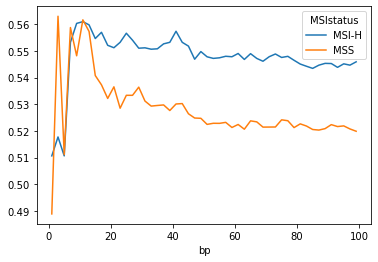

In [148]:
J2_gclong[J2_gclong["Gene"] == 'G1'].pivot(index = 'bp', columns = 'MSIstatus', values = 'GCcontent').plot.line()

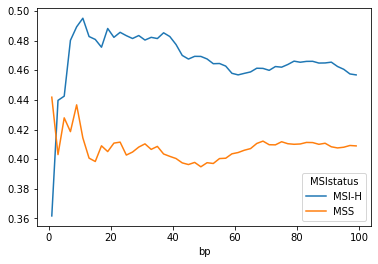

In [149]:
J2_gclong[J2_gclong["Gene"] == 'G2'].pivot(index = 'bp', columns = 'MSIstatus', values = 'GCcontent').plot.line()

# Plot GCcontent at individual base

## Junction 1 (J1)

In [172]:
def split_seq_to_base(df, seq_handle = "50+1+50", seqlen = 101):
    dt = df.copy()
    for i in range(0,seqlen):
        dt.insert(loc=i, column=i, value=dt[seq_handle].str[i])
    return dt

In [173]:
reversed_J1_basesb = split_seq_to_base(reversed_splitJ1)
reversed_J1_bases.tail()

,0,1,2,3,4,5,6,7,8,9,...,98,99,100,50+1+50,Chr,ID2,MSIstatus,Junction,Gene,strand
485,A,G,T,T,T,A,T,T,C,T,...,G,C,A,AGTTTATTCTAATGTATATACAAGCACCTAGCACATGCTCAGTATT...,chr7,GHF4YT_G2,MSS,J1,G2,+
486,A,T,T,T,T,A,C,A,T,A,...,A,A,T,ATTTTACATAATAGATGTCAAAATTTTAAAGAAGGTCCTAGTCTGT...,chr7,HTK8YS_G1,MSS,J1,G1,-
487,G,T,G,T,T,T,C,T,C,C,...,T,T,T,GTGTTTCTCCGTTCTCAGAGGCTTCCTTGGAAGCAGCTGTATCTGG...,chr3,HTK8YS_G2,MSS,J1,G2,+
488,T,A,A,A,A,A,A,A,A,C,...,A,C,G,TAAAAAAAACCAAAAAGCCCAAAACAAAAACAAAACAAAACAAAAA...,chr7,T52CP1_G1,MSS,J1,G1,-
489,A,C,A,C,A,C,T,A,G,C,...,A,T,G,ACACACTAGCGGTAATTGTGACCCTGAATAAATTACTTAACCTCTC...,chr7,T52CP1_G2,MSS,J1,G2,+


In [55]:
reversed_J1_bases_to_plot = GC_base_table(reversed_J1_bases).T
reversed_J1_bases_to_plot.tail()

,G1_MSI-H,G1_MSS,G2_MSI-H,G2_MSS
96,0.554348,0.543046,0.456522,0.379562
97,0.489130,0.430464,0.489130,0.408759
98,0.554348,0.483444,0.391304,0.408759
99,0.532609,0.476821,0.510870,0.408759
100,0.532609,0.496689,0.467391,0.386861


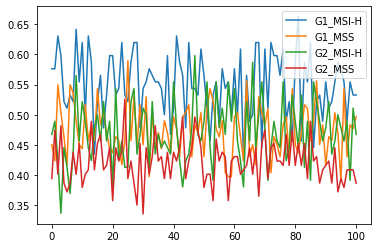

In [182]:
reversed_J1_bases_to_plot.plot.line()

## Junction 2 (J2)

In [42]:
reversed_J2_bases = split_seq_to_base(reversed_splitJ2)
reversed_J2_bases_to_plot = GC_base_table(reversed_J2_bases).T
reversed_J2_bases_to_plot.tail()

,G1_MSI-H,G1_MSS,G2_MSI-H,G2_MSS
96,0.468085,0.644444,0.340426,0.325581
97,0.659574,0.577778,0.361702,0.372093
98,0.340426,0.488889,0.276596,0.488372
99,0.659574,0.511111,0.468085,0.348837
100,0.468085,0.488889,0.319149,0.418605


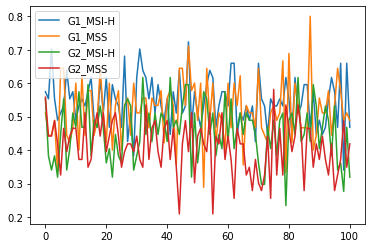

In [180]:
reversed_J2_bases_to_plot.plot.line()

# Save dataframe as csv

## symetric windows

In [66]:
J1_gccontinue = roughly_many_bp_GC(splitJ1, wings = range(0,50)).groupby(["Gene","MSIstatus"]).agg(np.mean)
J1_gccontinue.columns.name = "bp" # columns in a dataframe can also carry a name.
J1_gcstack = J1_gccontinue.stack()
J1_gcstack.name = "GCcontent" # set series name
J1_gclong = J1_gcstack.reset_index()
J1_gclong.insert(0, column="Junction", value="J1") # convert multiIndex series to a dataframe
J1_gclong['bp'] = pd.to_numeric(J1_gclong['bp']) # convert str to numeric
J1_gclong.tail()

,Junction,Gene,MSIstatus,bp,GCcontent
195,J1,G2,MSS,91,0.426315
196,J1,G2,MSS,93,0.425336
197,J1,G2,MSS,95,0.425584
198,J1,G2,MSS,97,0.425275
199,J1,G2,MSS,99,0.425447


In [65]:
J2_gccontinue = roughly_many_bp_GC(splitJ2, wings = range(0,50)).groupby(["Gene","MSIstatus"]).agg(np.mean)
J2_gccontinue.columns.name = "bp" # columns in a dataframe can also carry a name.
J2_gcstack = J2_gccontinue.stack()
J2_gcstack.name = "GCcontent" # set series name
J2_gclong = J2_gcstack.reset_index()
J2_gclong.insert(0, column="Junction", value="J2") # convert multiIndex series to a dataframe
J2_gclong['bp'] = pd.to_numeric(J2_gclong['bp']) # convert str to numeric
J2_gclong.tail()

,Junction,Gene,MSIstatus,bp,GCcontent
195,J2,G2,MSS,91,0.406838
196,J2,G2,MSS,93,0.405974
197,J2,G2,MSS,95,0.406550
198,J2,G2,MSS,97,0.407560
199,J2,G2,MSS,99,0.407407


In [69]:
GC_content_windows = pd.concat([J1_gclong, J2_gclong], ignore_index = True)
GC_content_windows.to_csv("GC_content_windows.csv")
GC_content_windows.tail()

,Junction,Gene,MSIstatus,bp,GCcontent
395,J2,G2,MSS,91,0.406838
396,J2,G2,MSS,93,0.405974
397,J2,G2,MSS,95,0.406550
398,J2,G2,MSS,97,0.407560
399,J2,G2,MSS,99,0.407407


## bases reversed according to strand

In [52]:
reversed_splitJ1 = reverse_sequence_for_crick_genes(J1_tbl, strand_ID2)
reversed_J1_bases = split_seq_to_base(reversed_splitJ1)
reversed_J1 = GC_base_table(reversed_J1_bases).reset_index()
reversed_J1["index"] = "J1_" + reversed_J1["index"]
reversed_J1.head(2)

,index,0,1,2,3,4,5,6,7,8,...,91,92,93,94,95,96,97,98,99,100
0,J1_G1_MSI-H,0.576087,0.576087,0.630435,0.597826,0.521739,0.510870,0.532609,0.521739,0.641304,...,0.510870,0.521739,0.554348,0.586957,0.576087,0.554348,0.489130,0.554348,0.532609,0.532609
1,J1_G1_MSS,0.450331,0.423841,0.549669,0.503311,0.463576,0.417219,0.549669,0.536424,0.490066,...,0.463576,0.456954,0.503311,0.470199,0.390728,0.543046,0.430464,0.483444,0.476821,0.496689


In [53]:
reversed_splitJ2 = reverse_sequence_for_crick_genes(J2_tbl, strand_ID2)
reversed_J2_bases = split_seq_to_base(reversed_splitJ2)
reversed_J2 = GC_base_table(reversed_J2_bases).reset_index()
reversed_J2["index"] = "J2_" + reversed_J2["index"]
reversed_J2.head(2)

,index,0,1,2,3,4,5,6,7,8,...,91,92,93,94,95,96,97,98,99,100
0,J2_G1_MSI-H,0.574468,0.553191,0.702128,0.553191,0.489362,0.510638,0.531915,0.638298,0.553191,...,0.446809,0.468085,0.553191,0.617021,0.574468,0.468085,0.659574,0.340426,0.659574,0.468085
1,J2_G1_MSS,0.511111,0.444444,0.444444,0.488889,0.333333,0.644444,0.644444,0.444444,0.422222,...,0.511111,0.511111,0.577778,0.444444,0.533333,0.644444,0.577778,0.488889,0.511111,0.488889


In [54]:
GC_content_reversed_bases = pd.concat([reversed_J1, reversed_J2], ignore_index = True)
GC_content_reversed_bases.to_csv("GC_content_reversed_bases.csv")
GC_content_reversed_bases

,index,0,1,2,3,4,5,6,7,8,...,91,92,93,94,95,96,97,98,99,100
0,J1_G1_MSI-H,0.576087,0.576087,0.630435,0.597826,0.521739,0.510870,0.532609,0.521739,0.641304,...,0.510870,0.521739,0.554348,0.586957,0.576087,0.554348,0.489130,0.554348,0.532609,0.532609
1,J1_G1_MSS,0.450331,0.423841,0.549669,0.503311,0.463576,0.417219,0.549669,0.536424,0.490066,...,0.463576,0.456954,0.503311,0.470199,0.390728,0.543046,0.430464,0.483444,0.476821,0.496689
2,J1_G2_MSI-H,0.467391,0.489130,0.423913,0.336957,0.445652,0.413043,0.369565,0.434783,0.565217,...,0.521739,0.434783,0.456522,0.500000,0.478261,0.456522,0.489130,0.391304,0.510870,0.467391
3,J1_G2_MSS,0.394161,0.474453,0.401460,0.481752,0.386861,0.372263,0.386861,0.437956,0.401460,...,0.423358,0.386861,0.445255,0.372263,0.394161,0.379562,0.408759,0.408759,0.408759,0.386861
4,J2_G1_MSI-H,0.574468,0.553191,0.702128,0.553191,0.489362,0.510638,0.531915,0.638298,0.553191,...,0.446809,0.468085,0.553191,0.617021,0.574468,0.468085,0.659574,0.340426,0.659574,0.468085
5,J2_G1_MSS,0.511111,0.444444,0.444444,0.488889,0.333333,0.644444,0.644444,0.444444,0.422222,...,0.511111,0.511111,0.577778,0.444444,0.533333,0.644444,0.577778,0.488889,0.511111,0.488889
6,J2_G2_MSI-H,0.553191,0.382979,0.340426,0.382979,0.319149,0.446809,0.553191,0.340426,0.404255,...,0.468085,0.531915,0.489362,0.382979,0.531915,0.340426,0.361702,0.276596,0.468085,0.319149
7,J2_G2_MSS,0.558140,0.441860,0.441860,0.488372,0.418605,0.325581,0.465116,0.395349,0.441860,...,0.441860,0.372093,0.325581,0.418605,0.279070,0.325581,0.372093,0.488372,0.348837,0.418605
